<a href="https://colab.research.google.com/github/MohamedddWael/Augmented_Reality_and_Image_Mosaics/blob/main/Augmented_Reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmented Reality

**This project includes the following steps:**


1. Finding correspondances between target book image and first frame in the book.mov video
2. Computing the Homography Matrix
3. Calculating book co-ordinates in the video
4. Cropping Ar video frames
5. Overlayying frames from the ar_source.mov video on the book.mov video (Augmented Reality Application)



In [353]:
#IMPORTING REQUIRED DEPENDENCIES
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import random
import os

### 1. Finding correspondances between target book image and first frame from the book.mov video

In [335]:
# Utility function for extracting frames from a video
def extract_frames(video_path):
  vidcap = cv2.VideoCapture(video_path)
  success,image = vidcap.read()
  frames = []
  count = 0
  while success:
    frames.append(image)
    success,image = vidcap.read()
    count += 1
  return frames

#test
#frames = extract_frames('book.mov')
#print(len(frames))
#cv2_imshow(frames[0])

In [336]:
def extract_correspondances(image1, image2, threshold= 0.75):
  sift = cv2.SIFT_create()

  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(image1,None)
  kp2, des2 = sift.detectAndCompute(image2,None)

  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)

  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < (threshold * n.distance):
          good.append([m])
  good = random.sample(good, 50)
  return kp1, kp2, good


def draw_correspondances(img1, kp1, img2, kp2, good):
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  cv2_imshow(img3)
  return img3

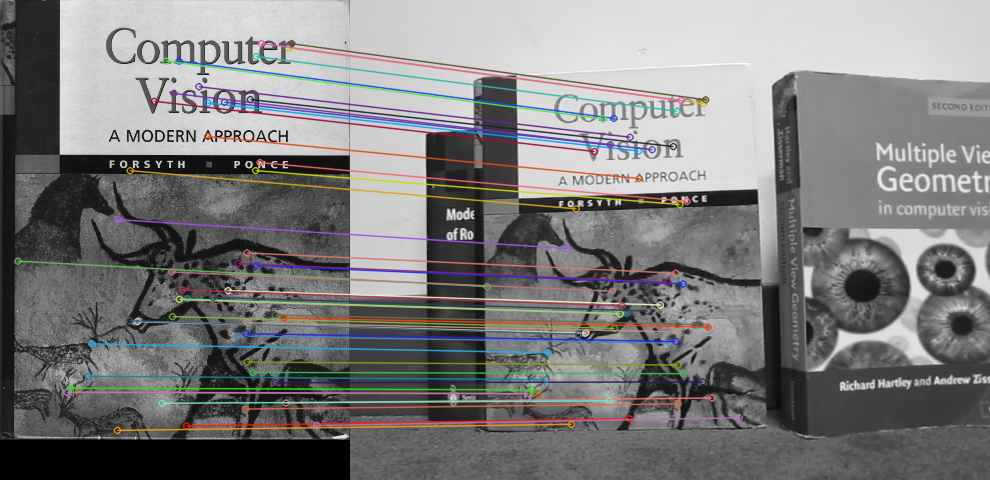

In [337]:
frames = extract_frames('book.mov')
image1 = cv2.imread('target_book.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
kp1, kp2, good = extract_correspondances(image1, image2)
image3 = draw_correspondances(image1, kp1, image2, kp2, good)

### 2. Computing the Homography Matrix

In [338]:
#Computing the A matrix
def compute_A(n, kp1, kp2):
  A = np.zeros((2*len(n), 8))
  for i in range(len(n)):
    x, y = kp1[n[i][0].queryIdx].pt
    x_prime, y_prime = kp2[n[i][0].trainIdx].pt
    A[2 * i, :] = [-x, -y, -1 , 0 , 0, 0, x * x_prime, y * x_prime]
    A[(2 * i) +1, :] = [0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y]
  return A

#Computing the b Matrix
def compute_b(n, kp1, kp2):
  b = np.zeros((2*len(n), 1))
  for i in range(len(n)):
    x_prime, y_prime = kp2[n[i][0].trainIdx].pt
    b[2*i] = -x_prime
    b[2*i+1] = -y_prime
  return b

In [339]:
#Function for computing the Homography Matrix
def compute_homography_least_squares(n, kp1, kp2):
  assert len(n) >= 4 , "Not enough correspondances"
  A = compute_A(n, kp1, kp2)
  b = compute_b(n, kp1, kp2)
  H = np.zeros((8,1))
  H = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, b))
  H = np.append(H, 1)
  H = np.reshape(H, (3, 3))
  assert H.shape == (3, 3), "Homography matrix shape is incorrect"
  return H

def builtin_homography(good, kp1, kp2):
  p = []
  p_primes = []
  for i in range(len(good)):
    x, y = kp1[good[i][0].queryIdx].pt
    x_prime, y_prime = kp2[good[i][0].trainIdx].pt
    p.append([x, y])
    p_primes.append([x_prime, y_prime])
  p = np.array(p)
  p_primes = np.array(p_primes)
  H, _ = cv2.findHomography(p, p_primes)
  return H

In [340]:
H = compute_homography_least_squares(good, kp1, kp2)
print(H)
print()
H_builtin = builtin_homography(good, kp1, kp2)
print(H_builtin)

[[ 7.93946138e-01  1.18130264e-02  1.17047375e+02]
 [-4.15661244e-02  7.95834959e-01  7.50685007e+01]
 [-6.16396636e-05 -4.71076152e-05  1.00000000e+00]]

[[ 7.95820508e-01  1.23540701e-02  1.16862938e+02]
 [-4.04516388e-02  7.97186269e-01  7.48237244e+01]
 [-5.81963424e-05 -4.54631984e-05  1.00000000e+00]]


In [341]:
#Mapping function from (x,y) to (x`, y`) using the computed Homography Matrix
def mapping_homography(H, x, y):
  x_prime = H[0][0]*x + H[0][1]*y + H[0][2]
  y_prime = H[1][0]*x + H[1][1]*y + H[1][2]
  return x_prime, y_prime

#Utility function for plotting the comparison between original and primes
def plot_coordinates(image, co_ordinates, original_coordinates):
    image_copy = image.copy()
    for i in range(len(co_ordinates)):
        cv2.circle(image_copy, (int(co_ordinates[i][0]), int(co_ordinates[i][1])), 3, (0, 0, 255), -1)
        cv2.circle(image_copy, (int(original_coordinates[i][0]), int(original_coordinates[i][1])), 3, (255,0 , 0), -1)
    cv2_imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.show()

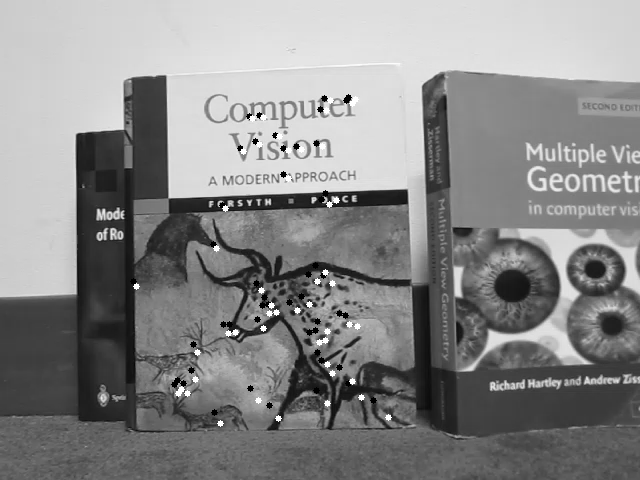

In [342]:
#Calculatine the prime co-ordinates using the computed Homography and comparing results. (There is some error due to an approximate resultant)
primes = []
non_primes = []
original_primes = []
for i in range(len(good)):
  x, y = kp1[good[i][0].queryIdx].pt
  non_primes.append([x, y])
  xx, yy = kp2[good[i][0].trainIdx].pt
  original_primes.append([xx, yy])
  x_prime, y_prime = mapping_homography(H, x, y)
  primes.append([x_prime, y_prime])
plot_coordinates(image2, primes, original_primes)

### 3. Calculating book co-ordinates in the video using the Homography matrix computed above

(440, 350)
[[  0   0]
 [  0 440]
 [350   0]
 [350 440]]


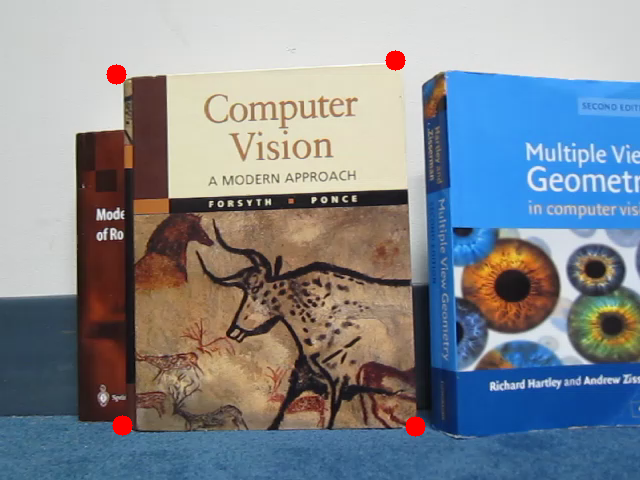

In [349]:
#utility functin for plotting dots on an image
def plot_single_coordinates(image, co_ordinates):
    image_copy = image.copy()
    for i in range(len(co_ordinates)):
        cv2.circle(image_copy, (int(co_ordinates[i][0]), int(co_ordinates[i][1])), 10, (0, 0, 255), -1)
    cv2_imshow(image_copy)
    plt.show()

#calculating book co-ordinates from the book cover image
print(image1.shape)
book_height = image1.shape[0]
book_width = image1.shape[1]
book_co_ordinates = np.array([[0,0],
                        [0, book_height],
                        [book_width, 0],
                        [book_width, book_height]])
print(book_co_ordinates)
prime_co_ordinates = []
for i in range(len(book_co_ordinates)):
  x, y = book_co_ordinates[i][0], book_co_ordinates[i][1]
  x_prime, y_prime = mapping_homography(H_builtin, x, y)
  prime_co_ordinates.append([x_prime, y_prime])
prime_co_ordinates = np.array(prime_co_ordinates)
prime_co_ordinates[3,1] = prime_co_ordinates[3,1] + 15
prime_co_ordinates[3,0] = prime_co_ordinates[3,0] + 15
plot_single_coordinates(frames[0], prime_co_ordinates)


### 4. Cropping Augmented Reality video frames

In [350]:
def crop_frames(frames, crop_width, crop_height):
  h, w = frames[0].shape[:2]
  aspect_ratio = crop_width / crop_height
  new_width = int(aspect_ratio*h)
  return np.array([frame[:, (w - new_width)//2:(w + new_width)//2] for frame in frames])

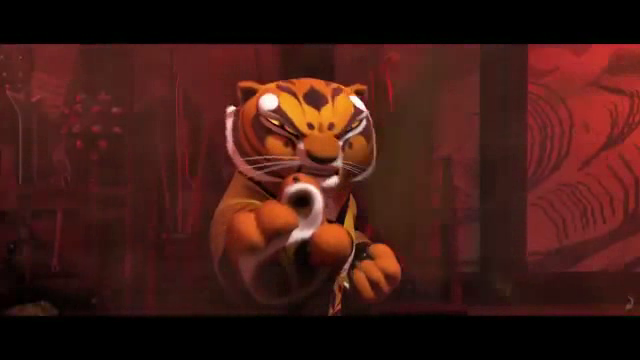

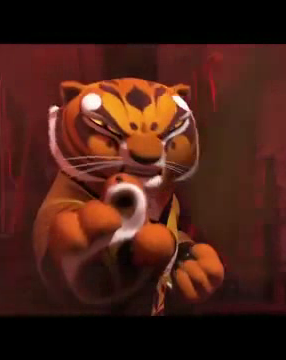

In [351]:
ar_frames = extract_frames('ar_source.mov')
cropped_frames = crop_frames(ar_frames, image1.shape[1], image1.shape[0])
cv2_imshow(ar_frames[104])
cv2_imshow(cropped_frames[104])

### 5. and 6. Augmented Reality Application:

In [364]:
def get_image_indices(image):
  return np.indices((image.shape[:2][::-1])).reshape(2, -1).T

def construct_video_from_frames(frames, video_name):
  h, w = frames[0].shape[:2]

  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(video_name, fourcc, 25, (w, h))

  for frame in frames:
    video.write(frame)

  return os.path.join(os.getcwd(), video_name)

def create_ar_video(book_cover, book_frames, cropped_source_frames, video_name):
  frames_to_add = len(book_frames) - len(cropped_source_frames)
  last_frame = cropped_source_frames[-1].copy()
  cropped_source_frames_new = np.concatenate((cropped_source_frames, [last_frame for _ in range(frames_to_add)]))

  gray_book_frames = [cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY) for book_frame in book_frames]
  frames = []
  cover_height, cover_width = book_cover.shape[:2]
  limit_height, limit_width = book_frames[0].shape[:2]

  for i in range(len(book_frames)):
    kp1, kp2, good = extract_correspondances(book_cover, gray_book_frames[i])
    homography_matrix = compute_homography_least_squares(good, kp1, kp2)

    resized_image = cv2.resize(cropped_source_frames_new[i], (cover_width, cover_height))

    old_pts = get_image_indices(resized_image)
    transformed_pts = []
    for j in range(len(old_pts)):
      transformed_pts.append(mapping_homography(homography_matrix, old_pts[j][0], old_pts[j][1]))

    frame = book_frames[i].copy()
    for old_pt, transformed_pt in zip(old_pts, transformed_pts):
      transformed_pt = (int(round(transformed_pt[0])), int(round(transformed_pt[1])))
      if transformed_pt[0] >= limit_width or transformed_pt[0] < 0 \
          or transformed_pt[1] >= limit_height or transformed_pt[1] < 0:
        continue
      frame[transformed_pt[1], transformed_pt[0]] = resized_image[old_pt[1]][old_pt[0]]

    frames.append(frame)

  return construct_video_from_frames(frames, video_name)

In [365]:
ar_video_name = 'ar_video.mov'
book_cover = cv2.imread('target_book.jpg')
ar_video_path = create_ar_video(image1, frames, cropped_frames, ar_video_name)